# Party List vs Constituency Vote Difference Analysis

Compare total votes each party received in **Party List (บัญชีรายชื่อ)** vs **Constituency (แบ่งเขต)** across all areas.

In [20]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Thai font support
plt.rcParams['font.family'] = 'Tahoma'

DATA_DIR = '../data/smiley159'

In [21]:
# Load raw data
with open(f'{DATA_DIR}/party-data.json') as f:
    party_raw = json.load(f)
with open(f'{DATA_DIR}/all-areas-constituency-results.json') as f:
    const_raw = json.load(f)
with open(f'{DATA_DIR}/all-areas-party-list-results.json') as f:
    pl_raw = json.load(f)

# Build party lookup: code -> {name, nameEn, color}
parties = {p['code']: p for p in party_raw['parties']}
print(f"Parties: {len(parties)}, Constituency areas: {len(const_raw['areas'])}, Party-list areas: {len(pl_raw['areas'])}")

Parties: 60, Constituency areas: 400, Party-list areas: 400


In [22]:
# Aggregate total votes per party for each election type
from collections import defaultdict

const_votes = defaultdict(int)
for area in const_raw['areas']:
    for entry in area['entries']:
        const_votes[entry['partyCode']] += entry['voteTotal']

pl_votes = defaultdict(int)
for area in pl_raw['areas']:
    for entry in area['entries']:
        pl_votes[entry['partyCode']] += entry['voteTotal']

# Build DataFrame with all parties that appear in either dataset
all_party_codes = set(const_votes.keys()) | set(pl_votes.keys())

rows = []
for code in all_party_codes:
    p = parties.get(code, {})
    rows.append({
        'party_code': code,
        'name': p.get('name', code),
        'name_en': p.get('nameEn', ''),
        'color': p.get('colorPrimary', '#999999'),
        'constituency_votes': const_votes.get(code, 0),
        'party_list_votes': pl_votes.get(code, 0),
    })

df = pd.DataFrame(rows)
df['diff'] = df['party_list_votes'] - df['constituency_votes']
df['diff_pct'] = ((df['diff'] / df['constituency_votes'].replace(0, float('nan'))) * 100).round(2)
df = df.sort_values('diff', ascending=False).reset_index(drop=True)

df[['name', 'name_en', 'constituency_votes', 'party_list_votes', 'diff', 'diff_pct']].head(20)

,name,name_en,constituency_votes,party_list_votes,diff,diff_pct
0,ประชาธิปัตย์,Democrat,2089723,3635139,1545416,73.95
1,ประชาชน,People's Party,8437906,9747116,1309210,15.52
2,เศรษฐกิจ,Economic,389332,1042928,653596,167.88
3,เพื่อชาติไทย,Pheu Chart Thai,480,627376,626896,130603.33
4,รวมใจไทย,Ruam Jai Thai,2791,402183,399392,14310.00
5,รวมไทยสร้างชาติ,United Thai Nation,306755,703381,396626,129.30
6,ใหม่,New,799,293827,293028,36674.34
7,ไทยทรัพย์ทวี,Thaisubthawee,2466,284090,281624,11420.28
8,มิติใหม่,New Dimension,1269,229899,228630,18016.55
9,ประชาธิปไตยใหม่,New Democracy,22422,237102,214680,957.45


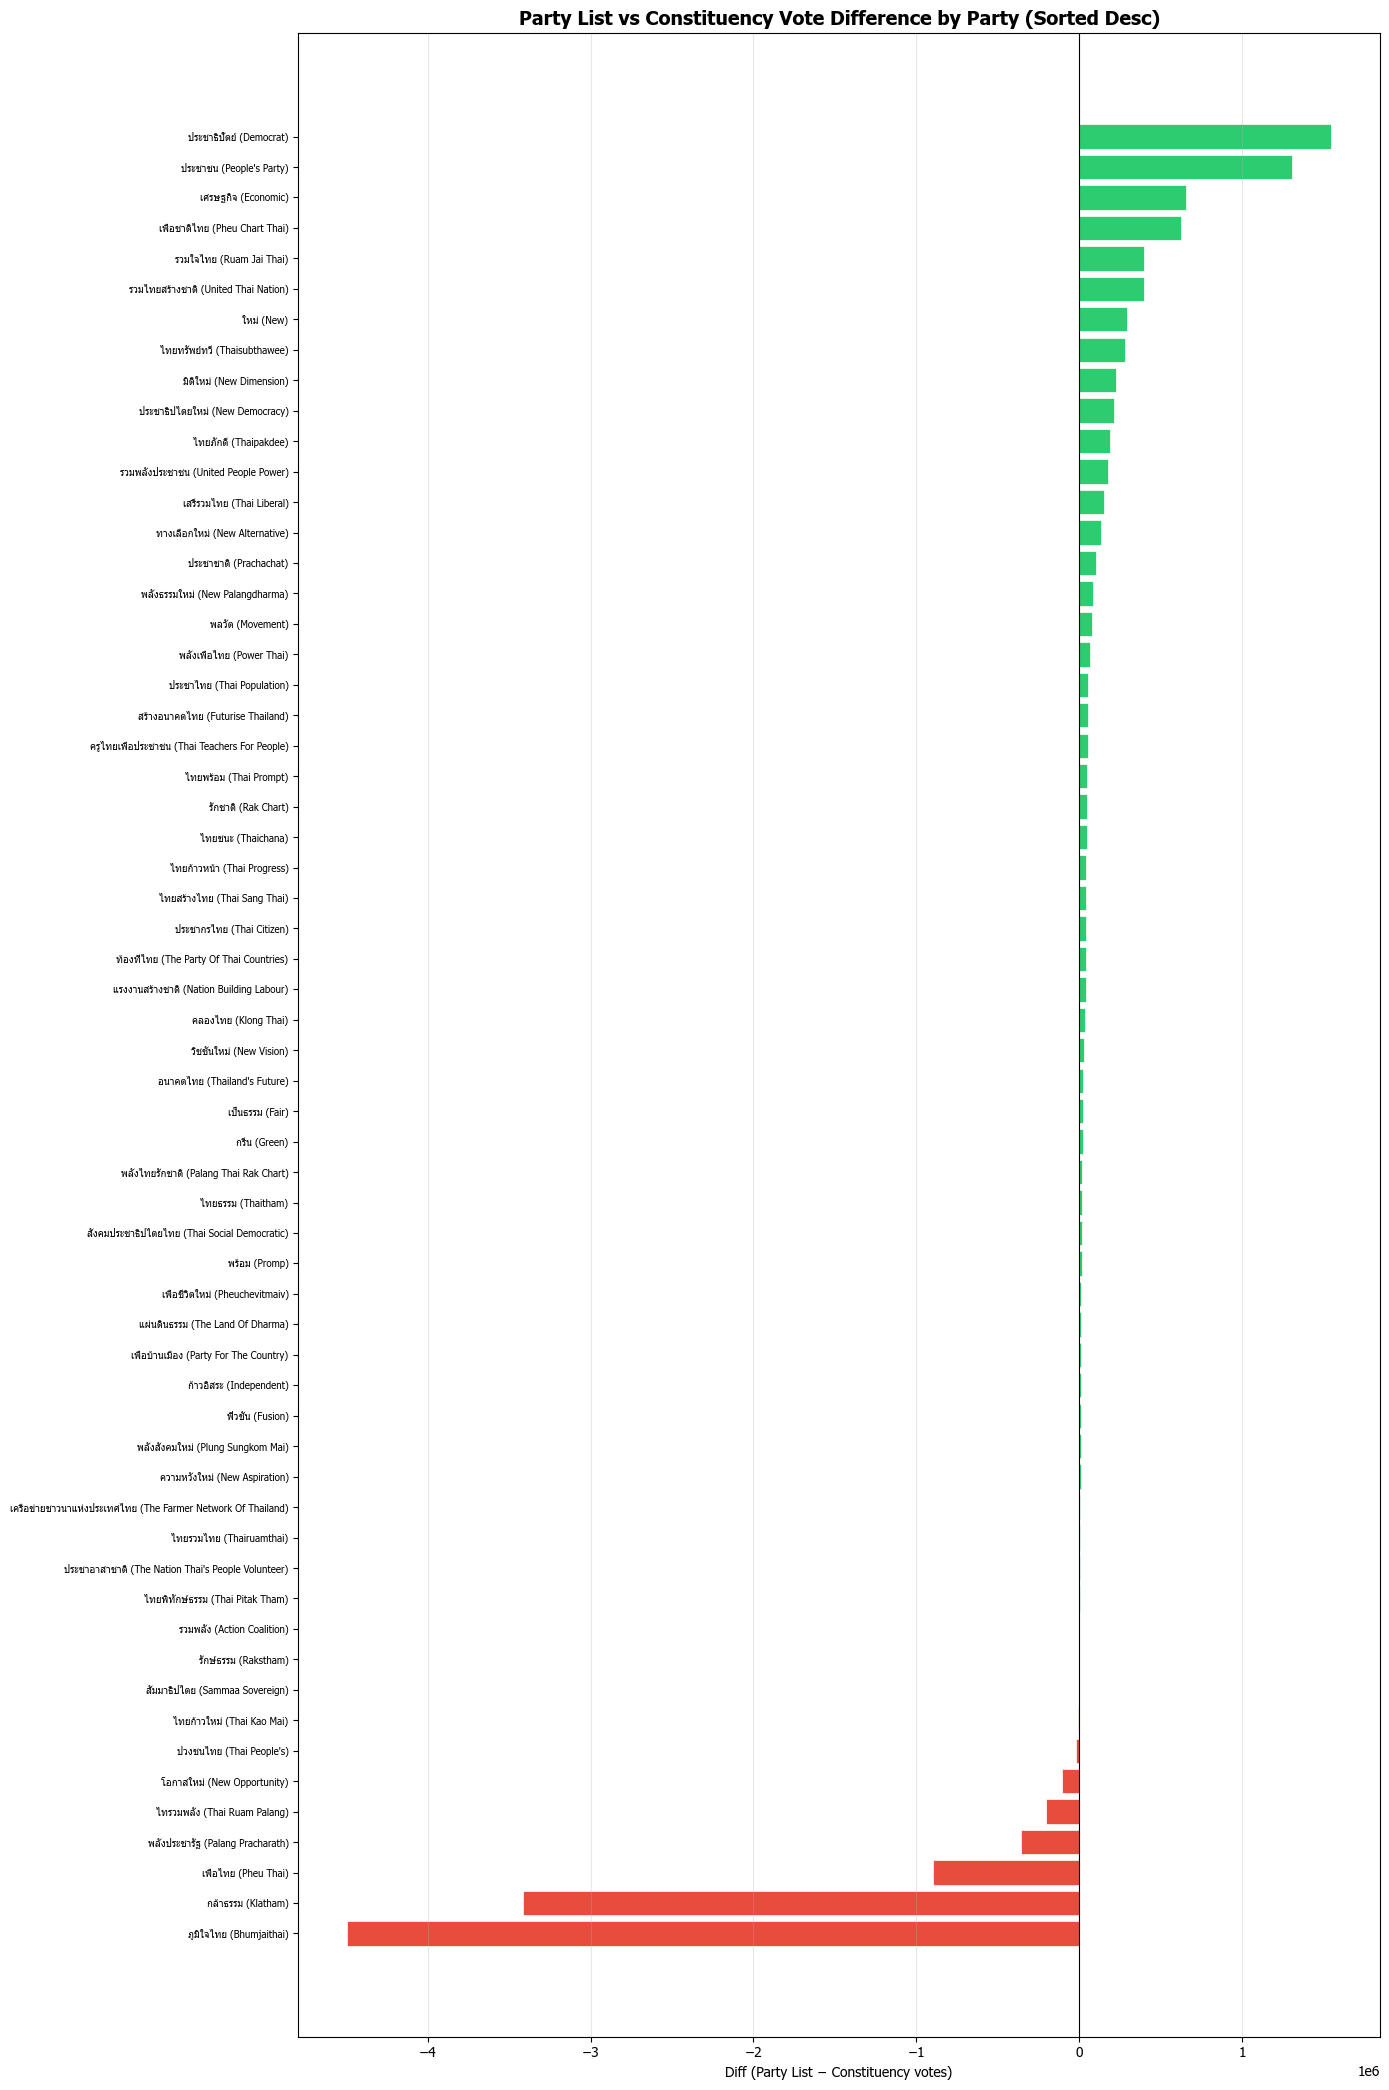

In [23]:
# Plot: all parties, ordered by diff descending
fig, ax = plt.subplots(figsize=(14, max(8, len(df) * 0.35)))

colors = ['#e74c3c' if d < 0 else '#2ecc71' for d in df['diff'].values[::-1]]

y_labels = [f"{row['name']} ({row['name_en']})" for _, row in df.iloc[::-1].iterrows()]
bars = ax.barh(range(len(df)), df['diff'].values[::-1], color=colors, edgecolor='white', linewidth=0.5)

ax.set_yticks(range(len(df)))
ax.set_yticklabels(y_labels, fontsize=7)
ax.set_xlabel('Diff (Party List − Constituency votes)')
ax.set_title('Party List vs Constituency Vote Difference by Party (Sorted Desc)', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

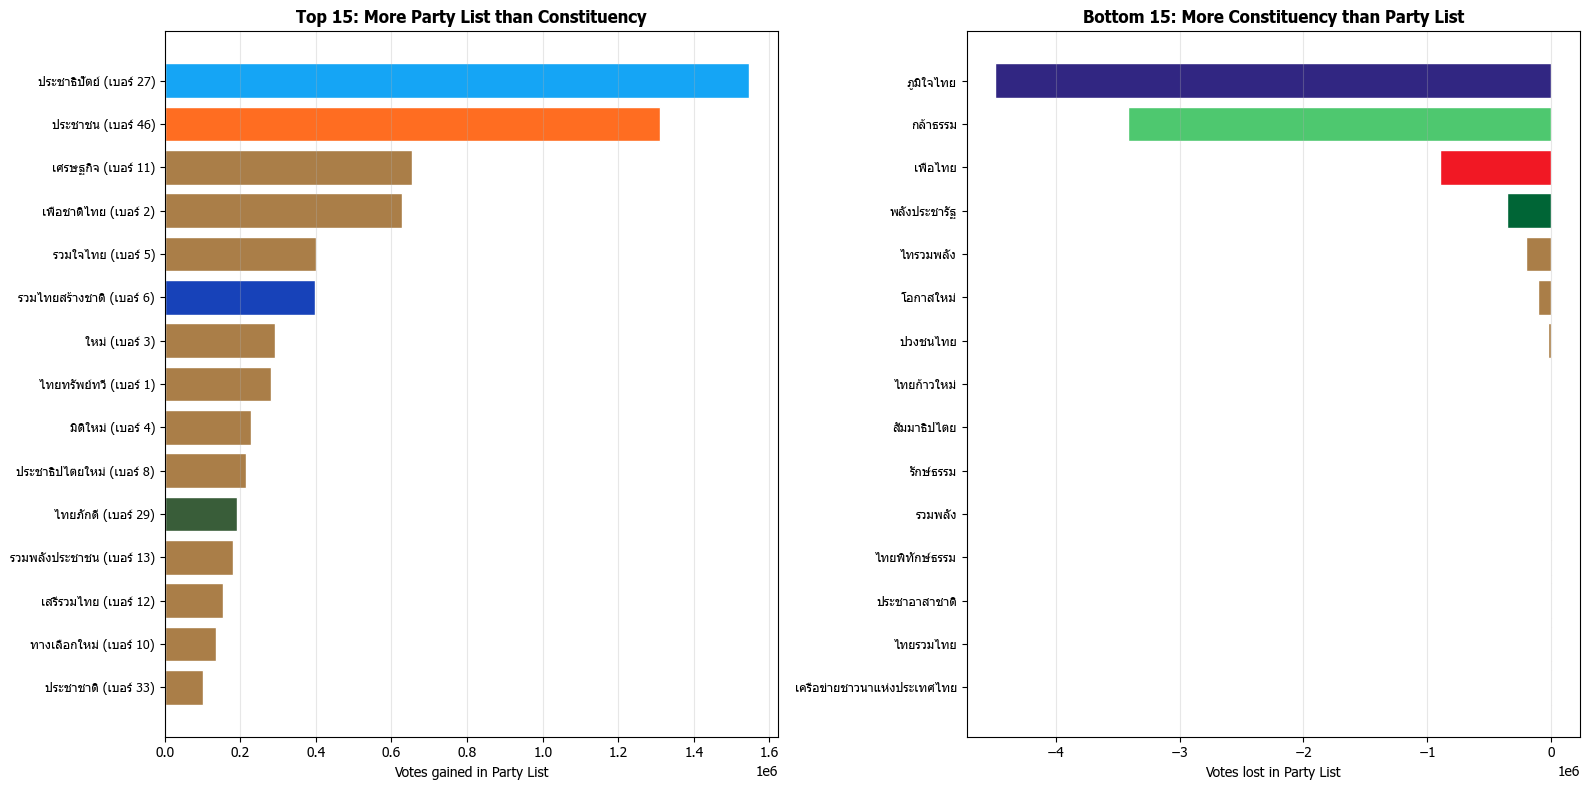

In [24]:
# Zoomed view: Top 15 and Bottom 15 parties by diff
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 (gained most from party list vs constituency)
top = df.head(15)
ax = axes[0]
bar_colors = [parties.get(c, {}).get('colorPrimary', '#999') for c in top['party_code']]
ax.barh(range(len(top)), top['diff'].values[::-1], color=bar_colors[::-1], edgecolor='white')
ax.set_yticks(range(len(top)))
ax.set_yticklabels([f"{r['name']} (เบอร์ {parties.get(r['party_code'], {}).get('number', '?')})" for _, r in top.iloc[::-1].iterrows()], fontsize=9)
ax.set_xlabel('Votes gained in Party List')
ax.set_title('Top 15: More Party List than Constituency', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Bottom 15 (lost most in party list vs constituency)
bottom = df.tail(15)
ax = axes[1]
bar_colors = [parties.get(c, {}).get('colorPrimary', '#999') for c in bottom['party_code']]
ax.barh(range(len(bottom)), bottom['diff'].values, color=bar_colors, edgecolor='white')
ax.set_yticks(range(len(bottom)))
ax.set_yticklabels([f"{r['name']}" for _, r in bottom.iterrows()], fontsize=9)
ax.set_xlabel('Votes lost in Party List')
ax.set_title('Bottom 15: More Constituency than Party List', fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Summary stats
print(f"Total parties: {len(df)}")
print(f"Parties with more Party List votes: {(df['diff'] > 0).sum()}")
print(f"Parties with more Constituency votes: {(df['diff'] < 0).sum()}")
print(f"Parties with equal votes: {(df['diff'] == 0).sum()}")
print()
print("Top 5 gainers (Party List − Constituency):")
for _, r in df.head(5).iterrows():
    print(f"  {r['name']:20s}  +{r['diff']:>10,} votes  ({r['diff_pct']:+.1f}%)")
print()
print("Top 5 losers (Party List − Constituency):")
for _, r in df.tail(5).iloc[::-1].iterrows():
    print(f"  {r['name']:20s}  {r['diff']:>10,} votes  ({r['diff_pct']:+.1f}%)")

Total parties: 60
Parties with more Party List votes: 49
Parties with more Constituency votes: 11
Parties with equal votes: 0

Top 5 gainers (Party List − Constituency):
  ประชาธิปัตย์          + 1,545,416 votes  (+74.0%)
  ประชาชน               + 1,309,210 votes  (+15.5%)
  เศรษฐกิจ              +   653,596 votes  (+167.9%)
  เพื่อชาติไทย          +   626,896 votes  (+130603.3%)
  รวมใจไทย              +   399,392 votes  (+14310.0%)

Top 5 losers (Party List − Constituency):
  ภูมิใจไทย             -4,492,951 votes  (-43.1%)
  กล้าธรรม              -3,412,726 votes  (-84.9%)
  เพื่อไทย                -896,806 votes  (-14.9%)
  พลังประชารัฐ            -354,441 votes  (-73.3%)
  ไทรวมพลัง               -200,529 votes  (-56.8%)


---
# Spillover Analysis (กระสุนหล่น)

For each small party-list number (เบอร์ 1, 2, 3, 4, 5, 8, 13), find **all** constituency candidates sharing that ballot number.
Then measure how many party-list votes the small party gains in those areas, broken down by which party's candidate caused the spillover.

In [26]:
# Load candidate data for ballot numbers
with open(f'{DATA_DIR}/candidate-data.json') as f:
    cand_raw = json.load(f)

cand_lookup = {c['code']: c for c in cand_raw['candidates']}
pl_number_to_code = {p['number']: p['code'] for p in party_raw['parties']}

TARGET_NUMBERS = [1, 2, 3, 4, 5, 8, 13]
target_pl_parties = {n: pl_number_to_code[n] for n in TARGET_NUMBERS}

# Build area-level lookups
area_pl = {}
for area in pl_raw['areas']:
    area_pl[area['areaCode']] = {e['partyCode']: e for e in area['entries']}

print("Target small parties:")
for n in TARGET_NUMBERS:
    code = target_pl_parties[n]
    p = parties[code]
    print(f"  เบอร์ {n:2d} -> {p['name']} ({p['nameEn']})")

Target small parties:
  เบอร์  1 -> ไทยทรัพย์ทวี (Thaisubthawee)
  เบอร์  2 -> เพื่อชาติไทย (Pheu Chart Thai)
  เบอร์  3 -> ใหม่ (New)
  เบอร์  4 -> มิติใหม่ (New Dimension)
  เบอร์  5 -> รวมใจไทย (Ruam Jai Thai)
  เบอร์  8 -> ประชาธิปไตยใหม่ (New Democracy)
  เบอร์ 13 -> รวมพลังประชาชน (United People Power)


In [27]:
# For each area & each constituency candidate whose ballot number matches a target small party,
# record the candidate's constituency votes and the small party's party-list votes
from collections import defaultdict

rows_spill = []

for area in const_raw['areas']:
    area_code = area['areaCode']
    pl_entries = area_pl.get(area_code, {})

    for entry in area['entries']:
        cand = cand_lookup.get(entry['candidateCode'])
        if not cand:
            continue
        ballot_num = cand['number']
        if ballot_num not in target_pl_parties:
            continue

        small_party_code = target_pl_parties[ballot_num]
        cand_party_code = cand['partyCode']

        # Skip if the candidate IS from the small party itself
        if cand_party_code == small_party_code:
            continue

        pl_entry = pl_entries.get(small_party_code)
        pl_votes = pl_entry['voteTotal'] if pl_entry else 0
        pl_pct = pl_entry['votePercent'] if pl_entry else 0.0

        rows_spill.append({
            'ballot_num': ballot_num,
            'small_party_code': small_party_code,
            'small_party_name': parties[small_party_code]['name'],
            'cand_party_code': cand_party_code,
            'cand_party_name': parties.get(cand_party_code, {}).get('name', cand_party_code),
            'cand_party_color': parties.get(cand_party_code, {}).get('colorPrimary', '#999'),
            'area_code': area_code,
            'const_votes': entry['voteTotal'],
            'const_pct': entry['votePercent'],
            'pl_votes': pl_votes,
            'pl_pct': pl_pct,
        })

df_spill = pd.DataFrame(rows_spill)
print(f"Total area-candidate-smallparty rows: {len(df_spill)}")

# Aggregate: for each (ballot_num, constituency party), sum across areas
agg = df_spill.groupby(['ballot_num', 'small_party_name', 'cand_party_code', 'cand_party_name', 'cand_party_color']).agg(
    areas=('area_code', 'count'),
    total_const_votes=('const_votes', 'sum'),
    total_pl_votes=('pl_votes', 'sum'),
    avg_pl_pct=('pl_pct', 'mean'),
).reset_index()
agg['spillover_rate'] = (agg['total_pl_votes'] / agg['total_const_votes'] * 100).round(2)
agg = agg.sort_values(['ballot_num', 'total_pl_votes'], ascending=[True, False])

# Show top contributors for each ballot number
for num in TARGET_NUMBERS:
    sub = agg[agg['ballot_num'] == num].head(5)
    small_name = sub['small_party_name'].iloc[0]
    print(f"\n=== เบอร์ {num}: {small_name} (party-list) ===")
    for _, r in sub.iterrows():
        print(f"  {r['cand_party_name']:20s}  {r['areas']:3.0f} areas  "
              f"const={r['total_const_votes']:>10,.0f}  "
              f"pl_gained={r['total_pl_votes']:>10,.0f}  "
              f"rate={r['spillover_rate']:.1f}%")

Total area-candidate-smallparty rows: 2289

=== เบอร์ 1: ไทยทรัพย์ทวี (party-list) ===
  ภูมิใจไทย              63 areas  const= 1,574,765  pl_gained=    83,076  rate=5.3%
  เพื่อไทย               69 areas  const= 1,093,447  pl_gained=    80,110  rate=7.3%
  กล้าธรรม               43 areas  const=   543,859  pl_gained=    42,483  rate=7.8%
  ประชาชน                64 areas  const= 1,252,345  pl_gained=    27,998  rate=2.2%
  ประชาธิปัตย์           52 areas  const=   321,820  pl_gained=    18,678  rate=5.8%

=== เบอร์ 2: เพื่อชาติไทย (party-list) ===
  ภูมิใจไทย              61 areas  const= 1,742,020  pl_gained=   149,706  rate=8.6%
  เพื่อไทย               56 areas  const=   821,032  pl_gained=   119,839  rate=14.6%
  ประชาชน                68 areas  const= 1,266,743  pl_gained=    93,887  rate=7.4%
  กล้าธรรม               41 areas  const=   620,607  pl_gained=    84,800  rate=13.7%
  ประชาธิปัตย์           52 areas  const=   337,380  pl_gained=    56,211  rate=16.7%

=== เบอร์ 3: ให

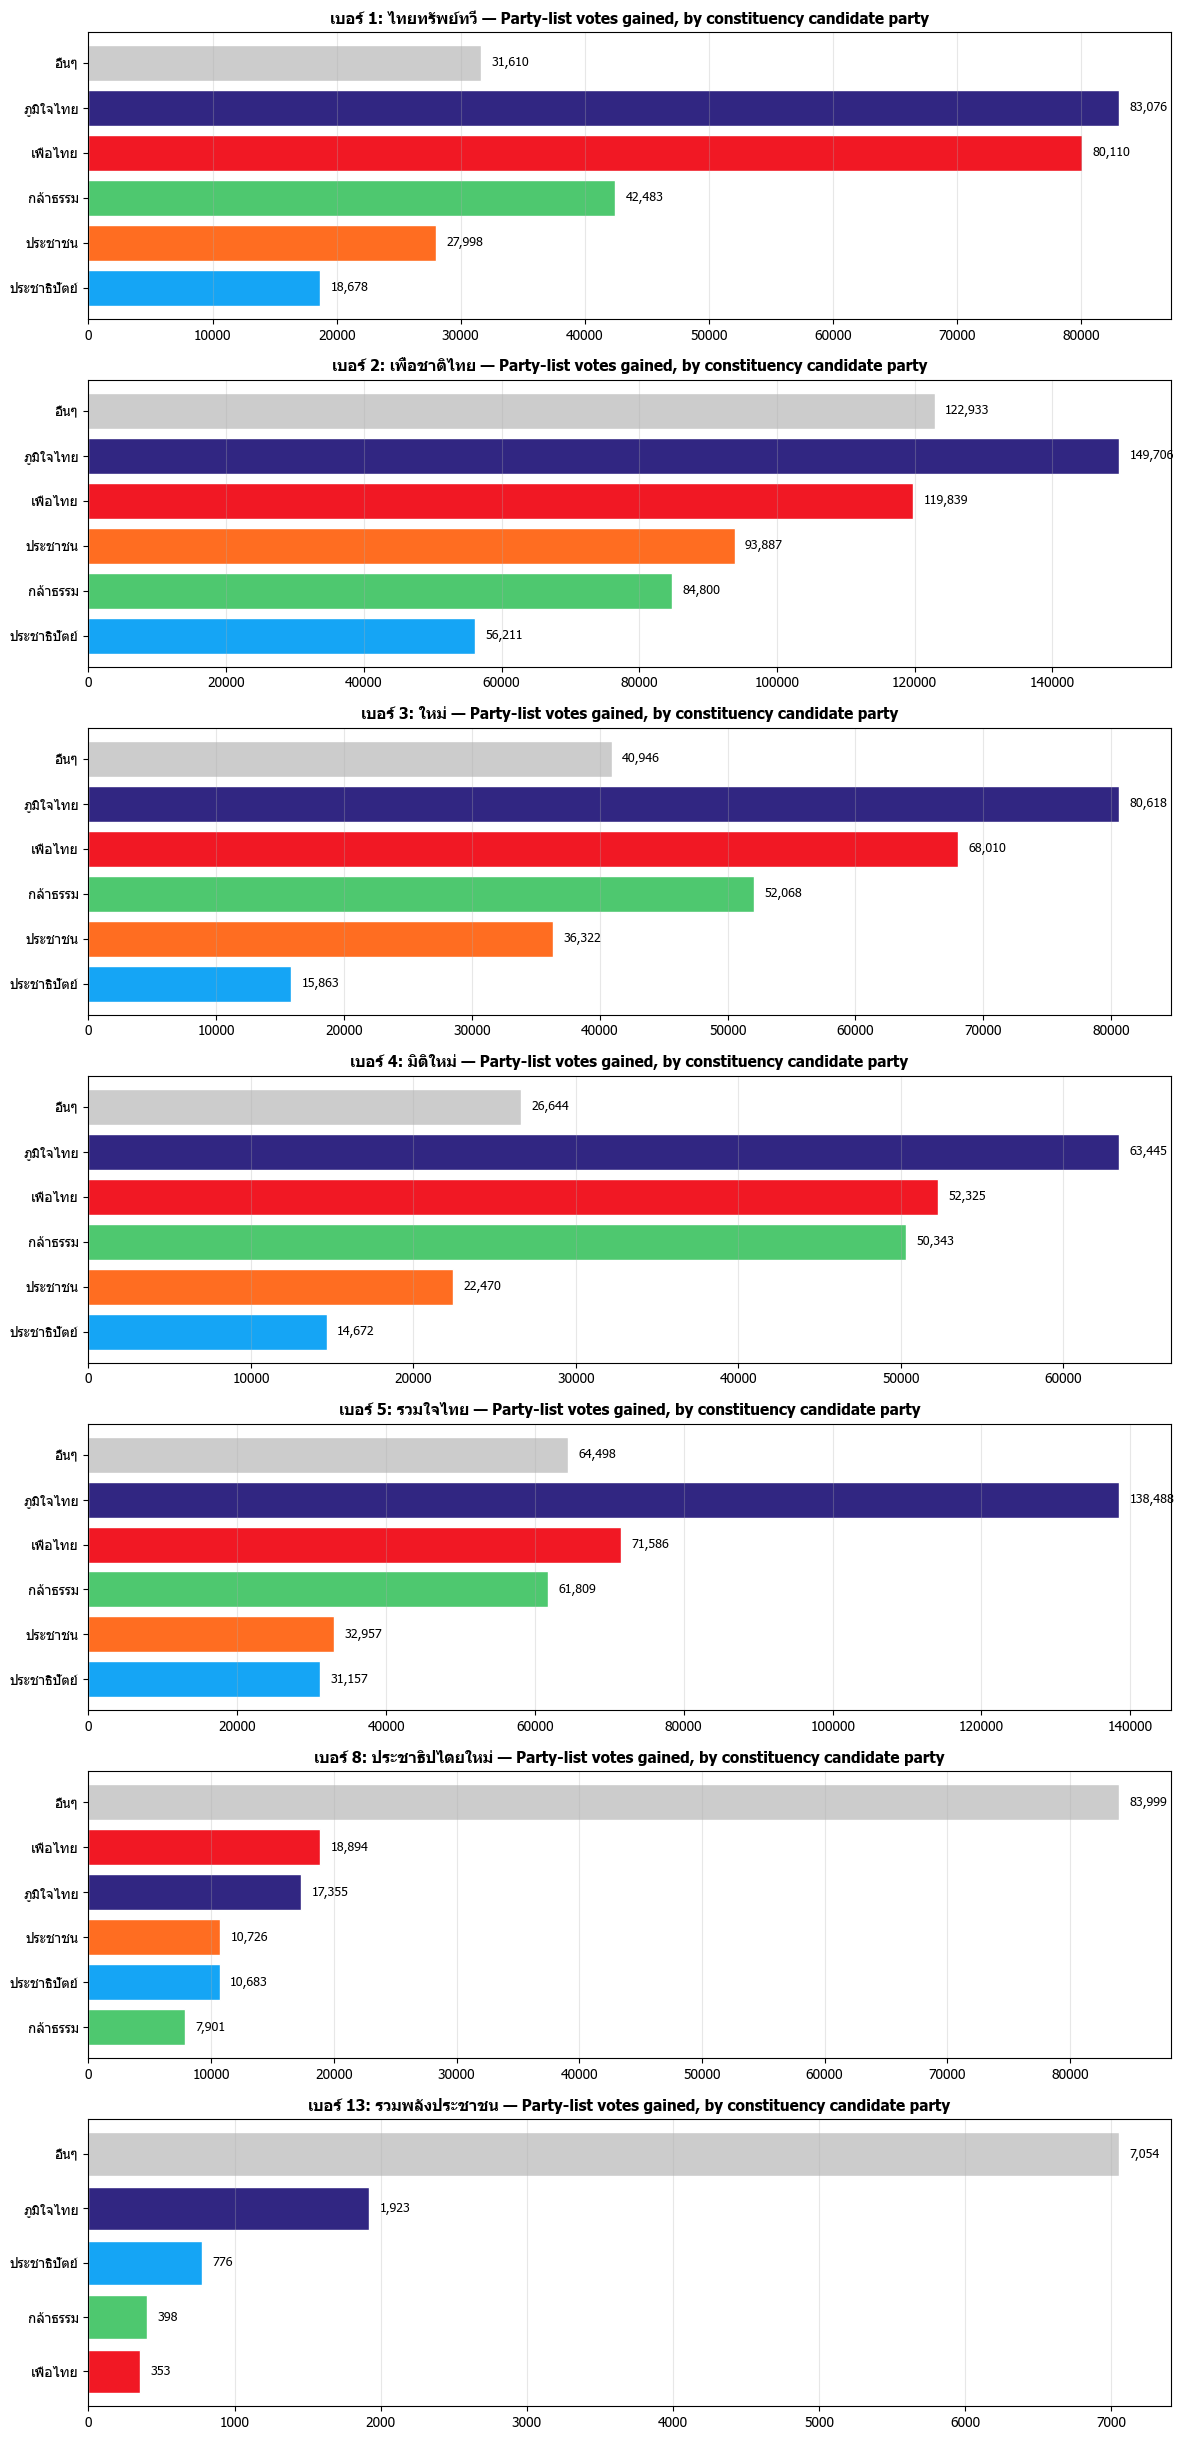

In [28]:
# Plot: For each small party, stacked bar showing which constituency parties cause the most spillover
BIG_5 = {'PARTY-0046', 'PARTY-0009', 'PARTY-0037', 'PARTY-0027', 'PARTY-0042'}
BIG_5_ORDER = ['PARTY-0037', 'PARTY-0009', 'PARTY-0046', 'PARTY-0042', 'PARTY-0027']

fig, axes = plt.subplots(len(TARGET_NUMBERS), 1, figsize=(12, 3.5 * len(TARGET_NUMBERS)))

for idx, num in enumerate(TARGET_NUMBERS):
    ax = axes[idx]
    sub = agg[agg['ballot_num'] == num].copy()
    small_name = sub['small_party_name'].iloc[0] if len(sub) > 0 else f'เบอร์ {num}'

    # Separate big-5 and others
    big5 = sub[sub['cand_party_code'].isin(BIG_5)].copy()
    others = sub[~sub['cand_party_code'].isin(BIG_5)]
    others_total = others['total_pl_votes'].sum()

    # Order big-5 by defined order
    big5['sort_key'] = big5['cand_party_code'].map({c: i for i, c in enumerate(BIG_5_ORDER)})
    big5 = big5.sort_values('total_pl_votes', ascending=True)

    labels = [r['cand_party_name'] for _, r in big5.iterrows()] + (['อื่นๆ'] if others_total > 0 else [])
    values = list(big5['total_pl_votes'].values) + ([others_total] if others_total > 0 else [])
    colors = [r['cand_party_color'] for _, r in big5.iterrows()] + (['#cccccc'] if others_total > 0 else [])

    bars = ax.barh(range(len(labels)), values, color=colors, edgecolor='white')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels, fontsize=10)
    ax.set_title(f'เบอร์ {num}: {small_name} — Party-list votes gained, by constituency candidate party', fontweight='bold', fontsize=11)
    ax.grid(axis='x', alpha=0.3)

    for i, v in enumerate(values):
        ax.text(v + max(values) * 0.01, i, f'{v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

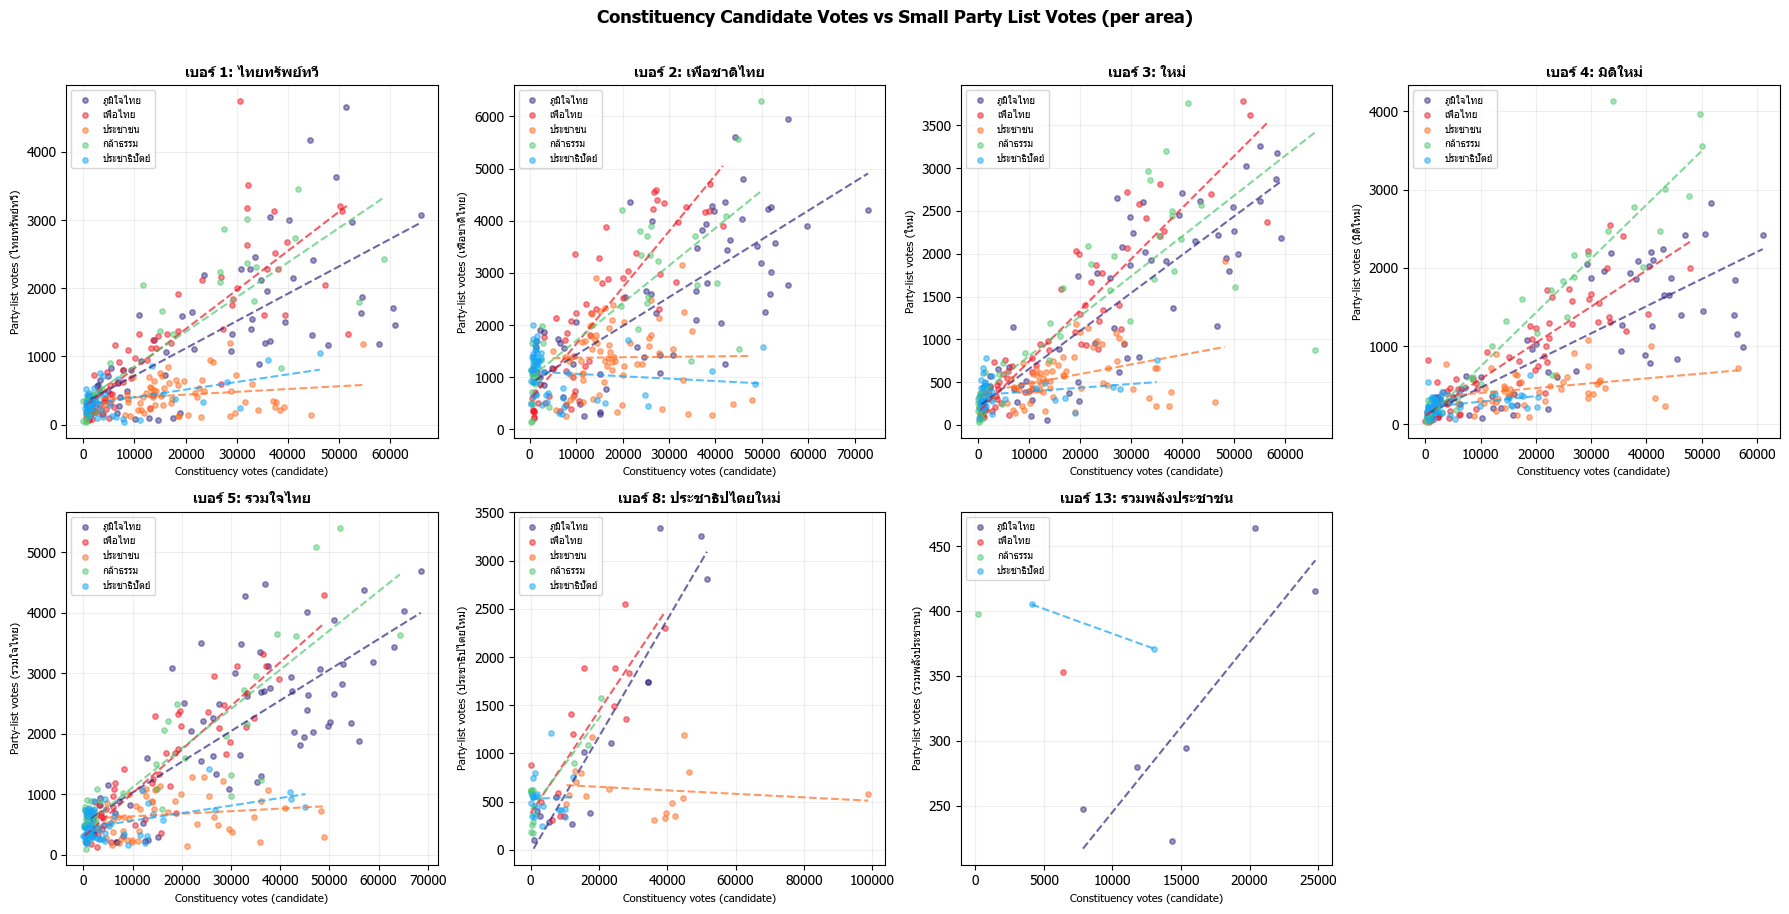

In [29]:
# Scatter: constituency candidate votes vs small party's party-list votes (per area)
# Each dot = one area, colored by the constituency candidate's party
import numpy as np

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

for idx, num in enumerate(TARGET_NUMBERS):
    ax = axes[idx]
    sub = df_spill[df_spill['ballot_num'] == num]
    small_name = parties[target_pl_parties[num]]['name']

    # Only plot big-5 candidates (they have the most votes and clearest signal)
    for pc in BIG_5_ORDER:
        mask = sub['cand_party_code'] == pc
        if mask.sum() == 0:
            continue
        d = sub[mask]
        p = parties.get(pc, {})
        color = p.get('colorPrimary', '#999')
        ax.scatter(d['const_votes'], d['pl_votes'], s=15, alpha=0.5,
                   color=color, label=p.get('name', pc))

        # Trend line (linear regression)
        if len(d) >= 2:
            x = d['const_votes'].values.astype(float)
            y = d['pl_votes'].values.astype(float)
            coeffs = np.polyfit(x, y, 1)
            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = np.polyval(coeffs, x_line)
            ax.plot(x_line, y_line, color=color, linewidth=1.5, alpha=0.7, linestyle='--')

    ax.set_xlabel('Constituency votes (candidate)', fontsize=8)
    ax.set_ylabel(f'Party-list votes ({small_name})', fontsize=8)
    ax.set_title(f'เบอร์ {num}: {small_name}', fontweight='bold', fontsize=10)
    ax.legend(fontsize=7, loc='upper left')
    ax.grid(alpha=0.2)

# Hide unused subplot
axes[-1].set_visible(False)

plt.suptitle('Constituency Candidate Votes vs Small Party List Votes (per area)', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()